### 1) Generate Option Prices Dataset

In [11]:
import time
import numpy as np
import pandas as pd
import scipy.stats as si
import matplotlib.pyplot as plt

In [12]:
### Functions

def monte_carlo(S,K,T,r,q,sigma,CallPut,n,m):
    '''
    Simple Monte Carlo option pricing algorithm for European Calls and Puts with Euler discretization
    
    Args:
        S - Initial Stock Price         sigma - Volatility
        K - Strike Price                CallPut - Option type specification (Call or Put)
        T - Time to Maturity            n - number of time steps for each MC path
        r - Risk-free interest rate     m - number of simulated paths
        q - Dividend rate
        
    Returns the simulated price of a European call or put with standard deviation and standard error
    associated with the simulation
    '''
    
    def path_sim(mu,sigma,T,S,N, M):
        '''Simulates M paths of Geometric Brownian Motion with N time steps'''
        sims = np.zeros(M) 
        dt = T/N

        for i in range(M):
            W = [0]+np.random.standard_normal(size=N)
            sims[i] = np.sum(W)*np.sqrt(dt) #We only are concerned with the terminal value for European options
        
        St = S*np.exp((mu-0.5*sigma**2)*T + sigma*sims)     
        return St
   
    paths = path_sim(r-q,sigma,T,S,n,m)
    
    if CallPut == 'Call':
        paths = paths - K
        paths[paths < 0] = 0    
    
    elif CallPut == 'Put':
        paths = K - paths
        paths[paths < 0] = 0
    
    c_hat = np.mean(paths)*np.exp(-r*T)
    
    sd = np.sqrt(np.sum((paths*np.exp(-r*T) - c_hat)**2)/(m-1))
    se = sd/np.sqrt(m)       
    return c_hat, sd, se


def monte_carlo_AV(S,K,T,r,q,sigma,CallPut,n,m):
    '''
    Monte Carlo option pricing algorithm for European Calls and Puts with Antithetic Variance Reduction
    with Euler discretization
    
    Args:
        S - Initial Stock Price         sigma - Volatility
        K - Strike Price                CallPut - Option type specification (Call or Put)
        T - Time to Maturity            n - number of time steps for each MC path
        r - Risk-free interest rate     m - number of simulated paths
        q - Dividend rate
        
    Returns the simulated price of a European call or put with standard deviation and standard error
    associated with the simulation
    '''
    def path_sim(mu,sigma,T,S,N, M):
        '''Simulates M paths of Geometric Brownian Motion with N time steps incorporating antithetic variance reduction'''
        sims = np.zeros(M)
        dt = T/N

        for i in range(M):
            W = [0]+np.random.standard_normal(size=N)
            sims[i] = np.sum(W)*np.sqrt(dt) #we are concerned with only the final value of the path
        
        St = S*np.exp((mu-0.5*sigma**2)*T + sigma*sims)
        Sta = S*np.exp((mu-0.5*sigma**2)*T - sigma*sims)    
        return np.array([St, Sta])
        
    paths = path_sim(r-q,sigma,T,S,n,m)
    
    if CallPut == 'Call':
        paths = paths - K
        paths[paths < 0] = 0
    
    elif CallPut == 'Put':
        paths = K - paths
        paths[paths < 0] = 0
    
    cT = np.mean(paths, axis=0)
    c_hat = np.mean(paths)*np.exp(-r*T)
    
    sd = np.sqrt(np.sum((cT*np.exp(-r*T) - c_hat)**2)/(m-1))
    se = sd/np.sqrt(m)
    return c_hat, sd, se


def monte_carlo_deltCV(S,K,T,r,q,sigma,CallPut,n,m):
    '''
    Monte Carlo European option pricing algorithm with Delta-based Control Variate with Euler discretization
    
    Args:
        S - Initial Stock Price         sigma - Volatility
        K - Strike Price                CallPut - Option type specification (Call or Put)
        T - Time to Maturity            n - number of time steps for each MC path
        r - Risk-free interest rate     m - number of simulated paths
        q - Dividend rate
    
    Returns the simulated price of a European call or put with standard deviation and standard error
    associated with the simulation
    '''
    def delta(S, K, T, r, sigma, c_p):
        '''Black-Scholes delta'''
        d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        if c_p == 'Call':    
            return si.norm.cdf(d1, 0.0, 1.0)
        elif c_p == 'Put':
            return si.norm.cdf(d1, 0.0, 1.0) - 1
        
    def path_sim(mu,sigma,T,S,N, M, cp,K):
        '''Simulates M paths of Geometric Brownian Motion with N time steps incorporating antithetic variance reduction'''
        sims = list(np.zeros(M));
        t = np.linspace(0,T,N);        dt = T/N
        ttm = np.flip(t) 
        erddt = np.exp((r-q)*dt)      
        for i in range(M):
            # GBM paths:
            W = [0]+np.random.standard_normal(size=N)
            W = np.cumsum(W)*np.sqrt(dt)
            St = S*np.exp((mu-0.5*sigma**2)*t + sigma*W)
            
            # Delta CV:
            d = delta(St[0:N-1],K,ttm[0:N-1],mu,sigma,cp)                
            cv = np.sum(d*(St[1:N] - (St[0:N-1]*erddt))*np.exp(mu*ttm[1:N]))
            sims[i] = [St[-1], cv]
        return np.array(sims).T

    paths = path_sim(r-q,sigma,T,S,n,m,CallPut,K)

    if CallPut == 'Call':
        # Option payoff:
        paths[0] = paths[0] - K
        paths[0][paths[0] < 0] = 0
        
        # Control Variate:
        paths = paths[0] - paths[1]
        
    elif CallPut == 'Put':
        # Option payoff:
        paths[0] = K - paths[0]
        paths[0][paths[0] < 0] = 0
        
        # Control Variate:
        paths = paths[0] - paths[1]
    
    c_hat = np.mean(paths)*np.exp(-r*T)    
    sd = np.sqrt(np.sum((paths*np.exp(-r*T) - c_hat)**2)/(m-1))
    se = sd/np.sqrt(m)
      
    return c_hat, sd, se


def monte_carlo_delt_gamCV(S,K,T,r,q,sigma,CallPut,n,m):
    '''
    Monte Carlo European option pricing algorithm with Delta-based and Gamma-based Control Variates with Euler discretization
    
    Args:
        S - Initial Stock Price         sigma - Volatility
        K - Strike Price                CallPut - Option type specification (Call or Put)
        T - Time to Maturity            n - number of time steps for each MC path
        r - Risk-free interest rate     m - number of simulated paths
        q - Dividend rate
    
    Returns the simulated price of a European call or put with standard deviation and standard error
    associated with the simulation
    '''
    def delta(S, K, T, r, sigma, CallPut):
        '''Black-Scholes delta'''
        d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        if CallPut == 'Call':    
            return si.norm.cdf(d1, 0.0, 1.0)
        elif CallPut == 'Put':
            return si.norm.cdf(d1, 0.0, 1.0) - 1
    
    def gamma(S, K, T, r, q, sigma):
        '''Black-Scholes gamma'''
        d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        return (np.exp(-q*T)/(S*sigma*np.sqrt(T))) * ((2*np.pi)**(-0.5)) * np.exp(-0.5*d1**2)
    
    def path_sim(r,q,sigma,T,S,N, M,CallPut,K):
        '''Simulates paths of Geometric Brownian motion while implementing the control variates'''
        sims = list(np.zeros(M));
        t = np.linspace(0,T,N);        dt = T/N
        ttm = np.flip(t) 
        erddt = np.exp((r-q)*dt)   
        egamma = np.exp((2*(r-q) + sigma**2)*dt) - 2*erddt + 1

        for i in range(M):
            # GBM path:
            W = [0]+np.random.standard_normal(size=N)
            W = np.cumsum(W)*np.sqrt(dt)
            St = S*np.exp((r-q-0.5*sigma**2)*t + sigma*W)
            
            # Delta CV:
            d = delta(St[0:N-1],K,ttm[0:N-1],r-q,sigma,CallPut)                
            cv_d = np.sum(d*(St[1:N] - (St[0:N-1]*erddt))*np.exp((r-q)*ttm[1:N]))
            
            # Gamma CV:
            g = gamma(St[0:N-1], K, ttm[0:N-1], r,q, sigma)     
            cv_g = np.sum(g*(((St[1:N] - St[0:N-1])**2) - egamma*St[0:N-1]**2)*np.exp((r-q)*ttm[1:N]))
            sims[i] = [St[-1], cv_d, cv_g]
        return np.array(sims).T
        
    paths = path_sim(r,q,sigma,T,S,n,m,CallPut,K)

    if CallPut == 'Call':
        # Option payoff:
        paths[0] = paths[0] - K
        paths[0][paths[0] < 0] = 0
        
        # Control Variates:
        paths = paths[0] - paths[1]- 0.5*paths[2]
        
    elif CallPut == 'Put':
        # Option payoff:
        paths[0] = K - paths[0]
        paths[0][paths[0] < 0] = 0
        
        # Control Variates:
        paths = paths[0] - paths[1] - 0.5*paths[2]
    
    c_hat = np.mean(paths)*np.exp(-r*T)    
    sd = np.sqrt(np.sum((paths*np.exp(-r*T) - c_hat)**2)/(m-1))
    se = sd/np.sqrt(m)
      
    return c_hat, sd, se



def monte_carlo_deltCV_AV(S,K,T,r,q,sigma,CallPut,n,m):
    '''
    Monte Carlo European option pricing algorithm with Delta-based Control Variate and Antithetic Variate
    with Euler discretization.
    
    Args:
        S - Initial Stock Price         sigma - Volatility
        K - Strike Price                CallPut - Option type specification (Call or Put)
        T - Time to Maturity            n - number of time steps for each MC path
        r - Risk-free interest rate     m - number of simulated paths
        q - Dividend rate
    
    Returns the simulated price of a European call or put with standard deviation and standard error
    associated with the simulation
    '''
    def delta(S, K, T, r, sigma, c_p):
        '''Black-Scholes delta'''
        d1 = (np.log(S/K) + T*(r + 0.5*sigma**2))/(sigma*np.sqrt(T))
        if c_p == 'Call':    
            return si.norm.cdf(d1, 0.0, 1.0)
        elif c_p == 'Put':
            return si.norm.cdf(d1, 0.0, 1.0) - 1
        
    def path_sim(mu,sigma,T,S,N, M, cp,K):
        '''Simulates M paths of Geometric Brownian Motion with N time steps incorporating antithetic variance reduction'''
        sims = list(np.zeros(M));
        t = np.linspace(0,T,N);        dt = T/N
        ttm = np.flip(t)  
        erddt = np.exp((r-q)*dt)    

        for i in range(M):         
            # GBM paths:
            W = [0]+np.random.standard_normal(size=N)
            W = np.cumsum(W)*np.sqrt(dt)
            St = S*np.exp((mu-0.5*sigma**2)*t + sigma*W);            Sta = S*np.exp((mu-0.5*sigma**2)*t - sigma*W)
            
            # Delta CV:
            d = delta(St[0:N-1],K,ttm[0:N-1],mu,sigma,cp);            da = delta(Sta[0:N-1],K,ttm[0:N-1],mu,sigma,cp)
            cv = np.sum(d*(St[1:N] - (St[0:N-1]*erddt))*np.exp(mu*ttm[1:N]))
            cva = np.sum(da*(Sta[1:N] - (Sta[0:N-1]*erddt))*np.exp(mu*ttm[1:N]))
            sims[i] = [St[-1], Sta[-1], cv, cva]
        
        return np.array(sims).T
    
    paths = path_sim(r-q,sigma,T,S,n,m,CallPut,K)

    if CallPut == 'Call':
        # Option payoff:
        paths[0] = paths[0] - K; paths[1] = paths[1] - K
        paths[0][paths[0] < 0] = 0; paths[1][paths[1] < 0] = 0
        
        # Control Variate:
        paths[0] = paths[0] - paths[2]
        paths[1] = paths[1] - paths[3]
        
    elif CallPut == 'Put':
        # Option payoff:
        paths[0] = K - paths[0]; paths[1] = K - paths[1]
        paths[0][paths[0] < 0] = 0; paths[1][paths[1] < 0] = 0
        
        # Control Variate:
        paths[0] = paths[0] + beta1*paths[2]
        paths[1] = paths[1] + beta1*paths[3]
    
    cT = np.mean(paths[0:2], axis=0)
    c_hat = np.mean(paths[0:2])*np.exp(-r*T)
    
    sd = np.sqrt(np.sum((cT*np.exp(-r*T) - c_hat)**2)/(m-1))
    se = sd/np.sqrt(m)
       
    return c_hat, sd, se



def monte_carlo_delt_gamCV_AV(S,K,T,r,q,sigma,CallPut,n,m):
    '''
    Monte Carlo European option pricing algorithm with Delta and Gamma-based Control Variate and Antithetic Variate.
    
    Args:
        S - Initial Stock Price         sigma - Volatility
        K - Strike Price                CallPut - Option type specification (Call or Put)
        T - Time to Maturity            n - number of time steps for each MC path
        r - Risk-free interest rate     m - number of simulated paths
        q - Dividend rate
    
    Returns the simulated price of a European call or put with standard deviation and standard error
    associated with the simulation
    '''
    def delta(S, K, T, r, sigma, c_p):
        '''Black-Scholes delta'''
        d1 = (np.log(S/K) + T*(r + 0.5*sigma*sigma))/(sigma*np.sqrt(T))
        if c_p == 'Call':    
            return si.norm.cdf(d1, 0.0, 1.0)
        elif c_p == 'Put':
            return si.norm.cdf(d1, 0.0, 1.0) - 1
        
    def gamma(S, K, T, r, q, sigma):
        '''Black-Scholes gamma'''
        d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        return (np.exp(-q*T)/(S*sigma*np.sqrt(T))) * ((2*np.pi)**(-0.5)) * np.exp(-0.5*d1**2)
    
        
    def path_sim(mu,sigma,T,S,N, M, cp,K):
        sims = list(np.zeros(M));
        t = np.linspace(0,T,N);        dt = T/N
        ttm = np.flip(t)  
        erddt = np.exp((r-q)*dt)    
        egamma = np.exp((2*(r-q) + sigma**2)*dt) - 2*erddt + 1

        for i in range(M):         
            # GBM paths
            W = [0]+np.random.standard_normal(size=N)
            W = np.cumsum(W)*np.sqrt(dt)
            St = S*np.exp((mu-0.5*sigma**2)*t + sigma*W);            Sta = S*np.exp((mu-0.5*sigma**2)*t - sigma*W)
            
            # Delta-based control variate
            d = delta(St[0:N-1],K,ttm[0:N-1],mu,sigma,cp);            da = delta(Sta[0:N-1],K,ttm[0:N-1],mu,sigma,cp)
            cv_d = np.sum(d*(St[1:N] - (St[0:N-1]*erddt))*np.exp(mu*ttm[1:N]))
            cva_d = np.sum(da*(Sta[1:N] - (Sta[0:N-1]*erddt))*np.exp(mu*ttm[1:N]))
            
            # Gamma-based control variate
            g = gamma(St[0:N-1], K, ttm[0:N-1], r,q, sigma);        ga = gamma(Sta[0:N-1],K,ttm[0:N-1],r,q,sigma)
            cv_g = np.sum(g*(((St[1:N] - St[0:N-1])**2) - egamma*St[0:N-1]**2)*np.exp((r-q)*ttm[1:N]))           
            cva_g = np.sum(ga*(((Sta[1:N] - Sta[0:N-1])**2) - egamma*Sta[0:N-1]**2)*np.exp((r-q)*ttm[1:N]))
            
            sims[i] = [St[-1], Sta[-1], cv_d, cva_d, cv_g, cva_g]
        return np.array(sims).T

    paths = path_sim(r-q,sigma,T,S,n,m,CallPut,K)

    if CallPut == 'Call':
        # Option payoff
        paths[0] = paths[0] - K;            paths[1] = paths[1] - K
        paths[0][paths[0] < 0] = 0;         paths[1][paths[1] < 0] = 0
        
        # Control Variates:
        paths[0] = paths[0] - paths[2] - 0.5*paths[4]
        paths[1] = paths[1] - paths[3] - 0.5*paths[5]
        
    elif CallPut == 'Put':
        # Option payoff
        paths[0] = K - paths[0];            paths[1] = K - paths[1]
        paths[0][paths[0] < 0] = 0;         paths[1][paths[1] < 0] = 0
        
        # Control Variates:
        paths[0] = paths[0] - paths[2] - 0.5*paths[4]
        paths[1] = paths[1] - paths[3] - 0.5*paths[5]
    
    cT = np.mean(paths[0:2], axis=0)
    c_hat = np.mean(paths[0:2])*np.exp(-r*T)

    sd = np.sqrt(np.sum((cT*np.exp(-r*T) - c_hat)**2)/(m-1))
    se = sd/np.sqrt(m)
       
    return c_hat, sd, se

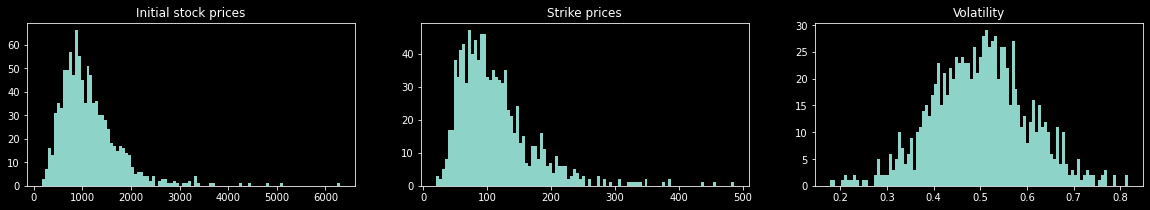

In [13]:
### MC Parameters

SAMPLES_COUNT = 1000

BINS_COUNT = 100


### Fixed

T = time_to_maturity = 1 # one year

n = time_steps_count = 1

m = paths_count = 10

CallPut = option_type = 'Call'


# Within bounds

q_min = dividend_rate_min = 0.01
q_max = dividend_rate_max = 0.1

q = dividend_rate = q_min

r_min = risk_free_interest_rate_min = 0.01
r_max = risk_free_interest_rate_max = 0.03

r = risk_free_interest_rate = r_min


# # Ranges

# S_min = initial_stock_price_min = 0
# S_max = initial_stock_price_min = 445000

# K_min = strike_price_min = 0
# K_max = strike_price_max = 445000

# sigma_min = volatility_min = 0
# sigma_max = volatility_max = 1


### Random

# Intial stock prices

lognormal_inner_mean = 0
lognormal_inner_sigma = 0.5

initial_stock_prices_mean = 1000

initial_stock_prices = np.random.lognormal(mean=lognormal_inner_mean,
                                           sigma=lognormal_inner_sigma,
                                           size=SAMPLES_COUNT)

initial_stock_prices *= initial_stock_prices_mean


# Strike prices

lognormal_inner_mean = 0
lognormal_inner_sigma = 0.5

strike_prices_mean = 100

strike_prices = np.random.lognormal(mean=lognormal_inner_mean,
                                    sigma=lognormal_inner_sigma,
                                    size=SAMPLES_COUNT)

strike_prices *= strike_prices_mean


# Volatilities

volatility_min = 0
volatility_max = 1

volatility_mean = 0.5
volatility_std = 0.1

def get_truncated_normal(minimum, maximum, mean, std):
    
    truncated_normal_distribution = si.truncnorm(
        (minimum - mean) / std, 
        (maximum - mean) / std, 
        loc=mean, 
        scale=std
    )
    
    return truncated_normal_distribution

truncated_normal_distribution = get_truncated_normal(minimum=volatility_min,
                                                     maximum=volatility_max,
                                                     mean=volatility_mean,
                                                     std=volatility_std)

volatilities = truncated_normal_distribution.rvs(SAMPLES_COUNT)


### Plot random parameters

plt.style.use('dark_background')

figure, row = plt.subplots(1, 3, figsize=(20, 3))

row[0].hist(initial_stock_prices, BINS_COUNT);
row[1].hist(strike_prices, BINS_COUNT);
row[2].hist(volatilities, BINS_COUNT);

row[0].set_title("Initial stock prices")
row[1].set_title("Strike prices")
row[2].set_title("Volatility");

# TODO: 
#
# Parameter change:
#     Single input price
#     Smaller initial price range
#     Sequential input prices
#
# Plot:
#     input_price -> option_price
#     input_price, volatility -> option_price
#
# SVM
#     second-order polinomial kernel
#     https://scikit-learn.org/stable/modules/svm.html#kernel-functions

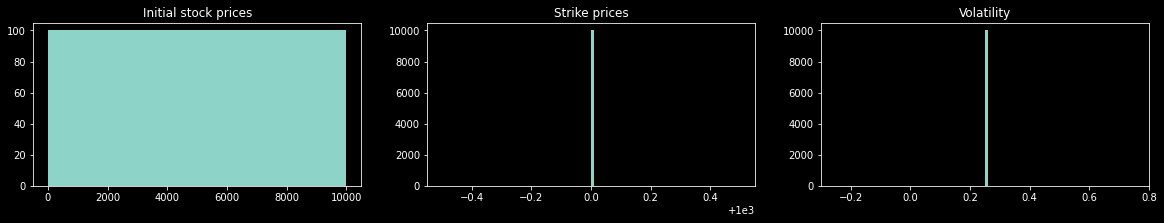

In [14]:
# Manual parameters

SAMPLES_COUNT = 10000
STRIKE_PRICE = 1000

incremental_range = list(range(SAMPLES_COUNT))

initial_stock_prices = incremental_range

strike_prices = [STRIKE_PRICE] * SAMPLES_COUNT

volatilities = [0.25] * SAMPLES_COUNT


### Plot random parameters

plt.style.use('dark_background')

figure, row = plt.subplots(1, 3, figsize=(20, 3))

row[0].hist(initial_stock_prices, BINS_COUNT);
row[1].hist(strike_prices, BINS_COUNT);
row[2].hist(volatilities, BINS_COUNT);

row[0].set_title("Initial stock prices")
row[1].set_title("Strike prices")
row[2].set_title("Volatility");

In [15]:
monte_carlo_functions = [
    {'name': 'monte_carlo', 'function': monte_carlo, 
     'description': "Simple Monte Carlo"},
    {'name': 'monte_carlo_AV', 'function': monte_carlo_AV, 
     'description': "MC with Antithetic Variance Reduction"},
    {'name': 'monte_carlo_deltCV', 'function': monte_carlo_deltCV, 
     'description': "MC with Delta-based Control Variate"},
    {'name': 'monte_carlo_delt_gamCV', 'function': monte_carlo_delt_gamCV, 
     'description': "MC with Delta-based and Gamma-based Control Variates "},
    {'name': 'monte_carlo_deltCV_AV', 'function': monte_carlo_deltCV_AV, 
     'description': "MC with Delta-based Control Variate and Antithetic Variate "},
    {'name': 'monte_carlo_delt_gamCV_AV', 'function': monte_carlo_delt_gamCV_AV, 
     'description': "MC with Delta and Gamma-based Control Variate and Antithetic Variate"},
]


def simulate_option_prices(function):
    
    option_prices = []
    dataset = []
    
    for initial_stock_price, strike_price, volatility in zip(initial_stock_prices, 
                                                             strike_prices, 
                                                             volatilities):
                
        result = function(S=initial_stock_price, 
                          K=strike_price,
                          T=time_to_maturity, 
                          r=risk_free_interest_rate,
                          q=dividend_rate, 
                          sigma=volatility, 
                          CallPut=option_type, 
                          n=time_steps_count,
                          m=paths_count)
        
        option_price, standard_deviation, standard_error = result
        
        option_prices.append(option_price)
        
        data = {'initial_stock_price': initial_stock_price,
                'strike_price': strike_price,
                'time_to_maturity': time_to_maturity,
                'risk_free_interest_rate': risk_free_interest_rate,
                'dividend_rate': dividend_rate,
                'volatility': volatility,
                'option_type': option_type,
                'time_steps_count': time_steps_count,
                'paths_count': paths_count,
                'simulated_price': option_price}
        
        dataset.append(data)
        
    return option_prices, dataset
   
    

def get_option_prices():

    selected_monte_carlo_functions = monte_carlo_functions[:1]
    

    for function_index, function in enumerate(selected_monte_carlo_functions):

        print(f"{function_index + 1}) {function['description']}")

        start_time = time.time()

        option_prices, dataset = simulate_option_prices(function['function'])

        execution_time = time.time() - start_time

        print(f"{len(option_prices)} samples - {execution_time:.2f} s.")


        # Plot

        plt.figure(figsize=(5, 3))

        plt.hist(option_prices, BINS_COUNT)
        plt.xlabel("Price")
        plt.ylabel("Samples count")

        plt.show()
        
    return option_prices, dataset

1) Simple Monte Carlo
10000 samples - 1.09 s.


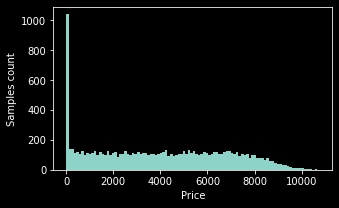

In [16]:
option_prices, dataset = get_option_prices()

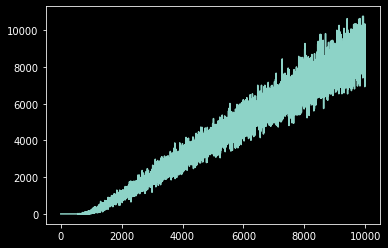

In [17]:
plt.plot(option_prices);

In [18]:
# dataset[:2]

In [19]:
# pip install openpyxl

In [20]:
# # Save dataset

# DATASET_FILE = '/workspace/projects/cuquantumdemo/finance/simulated_prices/option_prices_small.xlsx'

# df = pd.DataFrame(dataset)

# df.to_excel(DATASET_FILE)

In [21]:
# ls /workspace/projects/cuquantumdemo/finance/simulated_prices/

### 2) Changing Initial Stock Price

In [22]:
# Paramaters

initial_stock_prices = np.linspace(0, 10000, 101)

volatility = 0.25

strike_price = 1000

In [23]:
# Calculate Option prices

option_prices = []

for initial_stock_price in initial_stock_prices:
        
    result = monte_carlo(

        S=initial_stock_price, 
        K=strike_price,
        T=time_to_maturity, 
        r=risk_free_interest_rate,
        q=dividend_rate, 
        sigma=volatility, 
        CallPut=option_type, 
        n=time_steps_count,
        m=paths_count

    )

    option_price, standard_deviation, standard_error = result
    
    option_prices.append(option_price)
    
len(option_prices)

101

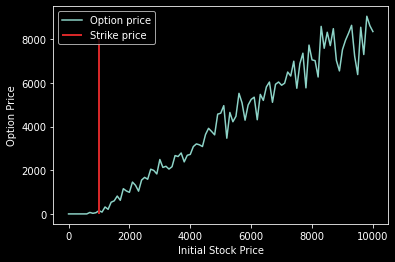

In [24]:
plt.plot(initial_stock_prices, option_prices, label="Option price")

plt.vlines(x=strike_price, ymin=0, ymax=8000, linewidth=2, color='tab:red', label="Strike price")

plt.xlabel('Initial Stock Price')
plt.ylabel('Option Price')

plt.legend()

plt.show()

### 3) Changing Initial Stock Price and Volatility

In [25]:
# Paramaters

initial_stock_prices = np.linspace(0, 10000, 101)

volatilities = np.linspace(0, 1.0, 101)

strike_price = 1000

In [31]:
# Calculate Option prices


option_prices_shape = len(initial_stock_prices), len(volatilities)

option_prices_meshgrid = np.zeros(option_prices_shape)

option_prices = []


for i, initial_stock_price in enumerate(initial_stock_prices):
    for j, volatility in enumerate(volatilities):
        
        result = monte_carlo(
            
            S=initial_stock_price, 
            K=strike_price,
            T=time_to_maturity, 
            r=risk_free_interest_rate,
            q=dividend_rate, 
            sigma=volatility, 
            CallPut=option_type, 
            n=time_steps_count,
            m=paths_count
        
        )

        option_price, standard_deviation, standard_error = result
        
        option_prices_meshgrid[i, j] = option_price
        
        row = (initial_stock_price, volatility, option_price)
        
        option_prices.append(row)
        

columns = ['initial_stock_price', 'volatility', 'option_price']        
        
option_prices_df = pd.DataFrame(option_prices, columns=columns)

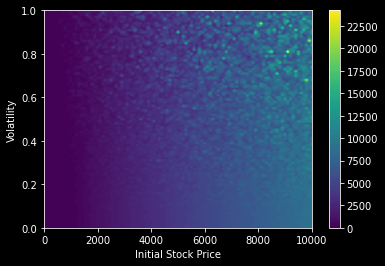

In [32]:
# Plot data

plt.contourf(initial_stock_prices, 
             volatilities,
             option_prices_meshgrid.T,
             levels=100)

plt.xlabel('Initial Stock Price')
plt.ylabel('Volatility')

plt.colorbar()
plt.show()

In [28]:
# # Save dataset

# DATASET_FILE = 'simulated_prices/option_prices_medium.xlsx'

# option_prices_df.to_excel(DATASET_FILE)

### Example 3D Animated Plot

In [20]:
import numpy as np

from matplotlib import pyplot as plt

from matplotlib import animation
from matplotlib.animation import PillowWriter

In [21]:
# Data

data_range = np.linspace(-1, 1, 100)
x, y = np.meshgrid(data_range, data_range)

results =  x ** 2 + x * y

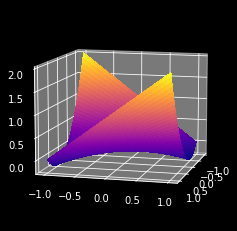

In [22]:
# 3D Animated Plot

FRAMES_COUNT = 10

ROTATION_PERIOD = 10

ELEVATION = 10


azimuth_step = 360 // FRAMES_COUNT

frames_per_second = FRAMES_COUNT // ROTATION_PERIOD


plt.style.use('dark_background')

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_surface(x, y, results,
                cmap='plasma',
                linewidth=0, 
                antialiased=False)

ax.view_init(elev=ELEVATION, azim=15)


def animate(frame_index):
    
    azimuth = frame_index * azimuth_step
    
    ax.view_init(elev=ELEVATION, azim=azimuth)
    
    
ani = animation.FuncAnimation(fig, animate, 
                              frames=FRAMES_COUNT, 
                              interval=50)

plt.show()

In [29]:
# # Show inline

# from IPython.display import HTML

# HTML(ani.to_jshtml())

In [24]:
# Save to GIF

# ani.save('images/animation.gif', writer='pillow', fps=frames_per_second, dpi=100)

### Option Prices - 3D Animated Plot

In [92]:
import numpy as np

from matplotlib import pyplot as plt

from matplotlib import animation
from matplotlib.animation import PillowWriter

In [93]:
# Data

initial_stock_prices_grid, volatilities_grid = np.meshgrid(initial_stock_prices, volatilities)

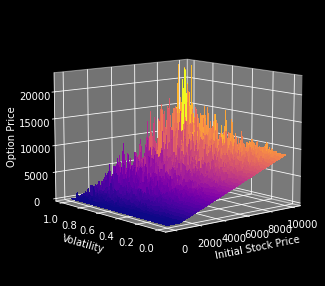

In [94]:
# 3D Animated Plot

FRAMES_COUNT = 120

ROTATION_PERIOD = 10

ELEVATION = 10

INITIAL_AZIMUTH = 230


azimuth_step = 360 // FRAMES_COUNT

frames_per_second = FRAMES_COUNT // ROTATION_PERIOD


plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(5, 5),
                       subplot_kw={"projection": "3d"})

surface = ax.plot_surface(initial_stock_prices_grid,
                          volatilities_grid,
                          option_prices_meshgrid.T,
                          cmap='plasma',
                          linewidth=30, 
                          antialiased=False)

ax.view_init(elev=ELEVATION, azim=INITIAL_AZIMUTH)


# ax.locator_params(axis='x', nbins=5)

ax.zaxis.set_rotate_label(False)

ax.set_xlabel('Initial Stock Price')
ax.set_ylabel('Volatility')
ax.set_zlabel('Option Price', rotation=90)

# ax.set_zlim(0, 20000)


def animate(frame_index):
    
    azimuth = frame_index * azimuth_step + INITIAL_AZIMUTH
    
    ax.view_init(elev=ELEVATION, azim=azimuth)
    
    
ani = animation.FuncAnimation(fig, animate, 
                              frames=FRAMES_COUNT, 
                              interval=50)

plt.show()

In [95]:
# Show inline

from IPython.display import HTML

HTML(ani.to_jshtml(fps=frames_per_second))

In [45]:
# # Save to GIF

# ani.save('images/option_prices.gif', writer='pillow', fps=frames_per_second, dpi=100)